                                       References
[HIRES PRV Documentation](https://caltech-ipac.github.io/hiresprv/hiresprv.html)

                                     Imports & Setup
                                        

In [1]:
from astropy import units as u
from astropy.io import fits
from hiresprv.auth import login
from hiresprv.idldriver import Idldriver
from hiresprv.database import Database
from hiresprv.download import Download
from PyAstronomy import pyasl
from specutils.fitting import fit_generic_continuum
from specutils.spectra import Spectrum1D

import numpy as np
import pandas as pd 


In [5]:
login('prv.cookies')                 # For logging into the NExSci servers 

idl = Idldriver('prv.cookies')       # For creating RV scripts 

state = Database('prv.cookies')      # For retrieving data from HIRES 

data = Download('prv.cookies', './output') # For downloading spectra

KOA userid: jgussman
KOA Password: ········
Successful login as jgussman


TypeError: __init__() should return None, not 'dict'

                                         Data 

In [3]:
# starnames_crossmatch_SPOCS_NEXSCI.txt was put together by Malena Rice 
# This matches SPOC stars with their HIRES ID 
crossMatchedNames = pd.read_csv("../spocData/starnames_crossmatch_SPOCS_NEXSCI.txt",sep=" ")

                                        RV Data

In [4]:
#Getting the RV data for each star
#1) Find all the RV observations 
def Find_and_download_all_rv_obs(star_ID_List,idldriver,database):
    '''    
    INPUT: star_ID_List is a list that contains strings of the HIRES ID for stars 
           idldriver needs be a hiresprv.idldriver.Idldriver instance 
           database needs to be hiresprv.database.Database instance 
    OUTPUT: {keys = HIRES filename: value = RV Data}
    
    Description: This function downloads the rotational velocity metadata and
    returns a dictionary that makes it easy to identify what stars' max observed 
    rotational velocities as well as the filenames for which they came from.
     
    '''
    rv_script_name_list = []
    problem_child_name = []
    problem_child_rv = []
    problem_child_filename = []
    master_script = ""
    for HIRESname in star_ID_List:
        try:
                #Create script for reducing RV observations
                temp_rv_script = idldriver.create_rvscript(HIRESname,database) 

                length_of_name = len(HIRESname)
                first_date = temp_rv_script[3+length_of_name:13+length_of_name].split(".")[0]

                HIRESrvname = temp_rv_script[3:length_of_name+3].split(" ")[0]

                temp_rv_script =  "template {0} {1}\n".format(HIRESrvname,first_date) + temp_rv_script
                temp_rv_script += "\nrvcurve {0}\n".format(HIRESrvname)
                rv_script_name_list.append(HIRESrvname)
                master_script += temp_rv_script

        except AttributeError: #This is due to the idldriver.create_rvscript 
            problem_child_name = [HIRESname] + problem_child_name
            problem_child_rv += [pd.NA]
            problem_child_filename += [pd.NA]
        
    #Run script 
    idldriver.run_script(master_script) 
    
    #Downloading the RV data as well as getting the largest RV value for each star
    largest_rv = {"HIRESName": problem_child_name,"FILENAME":problem_child_filename, "RV":problem_child_rv}  
    localdir = data.localdir
    for name in rv_script_name_list:
        #Make sure the data is in workspace
        largest_rv["HIRESName"].append(name)
        try:
            rtn = data.rvcurve(name)
            nameLoc = '{0}/vst{1}.csv'.format(localdir,name)
            temp_df = pd.read_csv(nameLoc)
            if not temp_df.empty:
                rv_temp = abs(temp_df['RV'])
                row = temp_df[temp_df['RV'] == rv_temp.min()]
                if row.empty: #The absolute max rv is negative 
                    row = temp_df[temp_df['RV'] == -rv_temp.min()]
                largest_rv["RV"] += [row["RV"].to_numpy()[0]]
                largest_rv["FILENAME"] += [row["FILENAME"].to_numpy()[0]]
            else:
                largest_rv["RV"] += [pd.NA]
                largest_rv["FILENAME"] += [pd.NA]
        except OSError: #This error occurs because for some reason the star's rvcurve wasn't created
                largest_rv["RV"] += [pd.NA]
                largest_rv["FILENAME"] += [pd.NA]
    return largest_rv

                                       Spectra

In [8]:
#Retreive all the Spectra 
def DownloadSpectra(filename_rv_df,download):
    '''
    Input: filename_rv_df dataframe with a column called "FILENAME" that contains the HIRES 
                          filename you want to download the deblazed spectra of. 
           download needs to be a hiresprv.download.Download instance 
   
    Output: {HIRES FILENAME: 1-D spectra array}
    
    Description: THIS FUNCTION ASSUMES YOU DID .dropna() ON filename_rv_df
    This function downloads all the 
    '''
    
    spectraDic = {} 
    download_Location = download.localdir #This is the second parameter of hiresprv.download.Download
    for filename in filename_rv_df["FILENAME"]:
        #I tried to use the , seperation and new line seperation 
        #for the different file names but it doesn't seem to work.
        #Thus, a for-loop was used!
        download.spectrum(filename.replace("r",""))  #Download spectra 
        
        temp_deblazedFlux = fits.getdata("{0}/{1}.fits".format(download_Location,filename))
        spectraDic[filename] = np.append(temp_deblazedFlux[0],[temp_deblazedFlux[i] for i in range(1,16)])     
    
    return spectraDic    

In [38]:
def ContinuumNormalize(spectraDic,download):
    '''
    ***NOT COMPLETE***
    Input: spectraDic is {HIRES FILENAME: 1-D spectra array}
           download needs to be a hiresprv.download.Download instance 
           
    Output: {HIRES FILENAME: 1-D continumm Normalized spectra}
    
    Description:
    '''
    #This is the same for all HIRES data 
    wl_solution = fits.getdata('http://caltech-ipac.github.io/hiresprv/_static/keck_rwav.fits')
    wl_solution = np.append(wl_solution[0],[wl_solution[i] for i in range(1,16)]) #UNITS: Angstrom
    wl_solution_micrometer = wl_solution*0.0001 #UNITS: µm
    spectral_axis_wl_solution = wl_solution*u.um
    photonEnergy = 1.2398 / wl_solution_micrometer #h*c/lambda = 1.2398 eV-µm/lambda 
    
    
    download_Location = download.localdir 
    #Continumm Normalize
    for filename in spectraDic:
        deblazedFlux = spectraDic[filename]
        hdu = fits.open("{0}/{1}.fits".format(download_Location,filename))
        timeElapsed = hdu[0].header["ELAPTIME"]
        hdu.close()
        photonsPersec = deblazedFlux/timeElapsed
    
        ergsPerSecFlux = photonEnergy*photonsPersec
        
        spectrum = Spectrum1D(flux=ergsPerSecFlux*u.Jy, spectral_axis=spectral_axis_wl_solution )
        g1_fit = fit_generic_continuum(spectrum)
        flux_fit = g1_fit(spectral_axis_wl_solution)
        
        flux_fit  = np.array(list(map(np.float,flux_fit/u.Jy)))
        normalized = ergsPerSecFlux - flux_fit
        spectraDic[filename] = normalized
        
    return spectraDic


In [51]:
def CrossCorrelate(filename_rv_df,normalized_Spectra):
    '''
    ***NOT COMPLETE***
    
    Input: 
   
    Output: 
    
    Description: THIS FUNCTION ASSUMES YOU DID .dropna() ON THE DATAFRAME
    '''
    wvnum, wvlen, crf, tel, c, n = np.genfromtxt("../Atlases/solarAtlas.txt",skip_header=1,unpack=True)
    wvnum, wvlen, crf, tel, c, n = wvnum[::-1], wvlen[::-1], crf[::-1], tel[::-1], c[::-1], n[::-1] 
    
    wl_solution = fits.getdata('http://caltech-ipac.github.io/hiresprv/_static/keck_rwav.fits')
    wl_solution = np.append(wl_solution[0],[wl_solution[i] for i in range(1,16)])
    
    crossCorrelatedspectra = {} #Key: FILENAME Values: (correlated wavelength, normalized flux)
    for i in range(filename_rv_df.shape[0]):
        row = filename_rv_df.iloc[i]
        filename = row[1]
        maxRV = abs(row[2])
        
        normalizedFlux = normalized_Spectra[filename]
        
        rv, cc = pyasl.crosscorrRV(wl_solution, normalizedFlux, wvlen,c, -1*maxRV, maxRV, maxRV/100., skipedge=25)
        maxind = np.argmax(cc)
        argmaxRV = rv[maxind]  #UNITS: km/s 
        
        # z = v_0/c    
        z = (argmaxRV/299_792.458) #UNITS: None 
        computeShiftedWavelength = lambda wl: wl + wl*z #UNITS: Angstroms 
        shifted_wl = np.array(list(map(computeShiftedWavelength,wl_solution)))
        
        #Making the key the HIRES ID so I easily convert it back to the Spoc ID later
        crossCorrelatedspectra[row[0]] = (shifted_wl,normalizedFlux) 
    
    return crossCorrelatedspectra

In [58]:
def Interpolate(spectraDic):
    '''
    ***NOT COMPLETE***
    
    Input: 
   
    Output: 
    
    Description: THIS FUNCTION ASSUMES YOU DID .dropna() ON THE DATAFRAME
    '''
    
    #Interpolate the spectra with each other to get the same wavelength scale for all of them.
    firstKey = next(iter(spectraDic))
    first_spectra = spectraDic[firstKey][0]
    wl_length = len(first_spectra)
    
    
    maxMinVal = float('-inf')
    minMaxVal = float('inf')
    #Finds the max minimum wavelength val & finds the min maximum wavelenght val 
    for spectra_flux_tuple in spectraDic.values(): 
        #Assumption: wavelength is sorted from the 0th index being min,
        #            the len(wavelength array)-1 is the max wavelength val,
        #            all the wavelength arrays are the same length.
        temp_spectra = spectra_flux_tuple[0]
        temp_min_wl = temp_spectra[0]
        temp_max_wl = temp_spectra[wl_length-1]
        
        if maxMinVal < temp_min_wl:
            maxMinVal = temp_min_wl
        if minMaxVal > temp_max_wl:
            minMaxVal = temp_max_wl
    
    
    interpolate_over = [wl for wl in first_spectra if wl >= maxMinVal and wl<=minMaxVal]
    
    fluxDic = {}
    for HIRES_ID in spectraDic:
        wl = spectraDic[HIRES_ID][0]
        flux_norm = spectraDic[HIRES_ID][1]
        interpolated_flux = np.interp(interpolate_over,x,flux_norm)
        fluxDic[HIRES_ID] = interpolated_flux
    
    #Saving 
    np.savetxt("interpolated_wl.csv",interpolate_over,delimiter=",")
    fluxDF = pd.DataFrame(fluxDic)
    fluxDF.to_csv("fluxes_for_HIRES.csv",index_label=False,index=False)
    return fluxDF
    

                                       Running

In [6]:
#RV
name_filename_rv_dic = Find_and_download_all_rv_obs(crossMatchedNames["HIRES"].to_numpy(),idl,state)
name_filename_rv_df = pd.DataFrame(name_filename_rv_dic)
name_filename_rv_df.to_csv("HIRES_Filename_rv.csv",index_label=False,index=False)

status= ok
msg= Script running in background. Consult monitor for status.


In [9]:
#Download Spectra 
#I'm testing different function at different times. That is why I am not using 
#name_filename_rv_df 
name_filename_rv_df = pd.read_csv("HIRES_Filename_rv.csv").dropna() 
data = Download('prv.cookies', './spectraOutput') # For downloading spectra
spectraForStars = DownloadSpectra(name_filename_rv_df,data)

In [39]:
#Continum Normalize
###-------DELETE THIS FROM HERE------------
data = Download('prv.cookies', './spectraOutput')
name_filename_rv_df = pd.read_csv("HIRES_Filename_rv.csv").dropna()
spectraDic = {}
download_Location = data.localdir 
for filename in name_filename_rv_df["FILENAME"]:
    temp_deblazedFlux = fits.getdata("{0}/{1}.fits".format(download_Location,filename))
    spectraDic[filename] = np.append(temp_deblazedFlux[0],[temp_deblazedFlux[i] for i in range(1,16)])     
spectraForStars = spectraDic 
import time 
start_time  = time.time()
normalizedSpectraDic = ContinuumNormalize(spectraForStars,data)
end_time = time.time() - start_time 
print(f"It took {end_time/60} minutes to complete continumm normalize on 751 objects")
###------STOP DELETING HERE------------


# normalizedSpectra = ContinuumNormalize(spectraForStars,data)

It took 39.51186061700185 minutes to complete continumm normalize on ~700 objects


In [53]:
crossCorrelatedSpectra = CrossCorrelate(name_filename_rv_df,normalizedSpectraDic)

In [59]:
Interpolate(crossCorrelatedSpectra)

,33822,72905,109409,26965,38858,34411,50692,66428,62613,61994,...,75407,141937,109749,117207,130322,179306,1666,2564,231701,192263
0,4.247730,-214.364208,-55.602183,-828.024643,-304.063078,-603.129723,-322.642104,-13.947193,-248.747221,-49.851466,...,-66.580834,-147.146712,-8.203871,-43.064300,-59.496024,-50.950006,-48.008949,-146.660779,-27.061961,-23.572152
1,1.312820,-217.441927,-89.060598,-778.178320,-279.962716,-712.313409,-287.463902,-13.530516,-307.704991,-39.353261,...,-69.277565,-135.178834,-8.933408,-49.336221,-50.306605,-43.229296,-52.679343,-138.750231,-28.471641,-10.463437
2,-3.467142,-238.896615,-124.110722,-1226.823528,-266.928499,-602.562106,-284.577511,-13.278602,-393.497036,-28.850710,...,-86.721305,-121.656175,-8.025398,-41.265164,-39.719137,-34.345048,-51.759342,-128.859771,-27.553201,-4.196998
3,-10.852873,-252.322276,-151.450945,-1362.908743,-265.562754,-625.034939,-263.702388,-12.755023,-466.844495,-40.154237,...,-107.734253,-108.516284,-9.131776,-57.040812,-40.829017,-26.614133,-52.399073,-121.657986,-28.426799,-1.982406
4,-18.360899,-286.283744,-183.003485,-2102.633319,-263.145817,-579.307440,-253.154217,-12.600095,-540.690303,-30.407370,...,-132.419344,-100.835776,-8.441248,-60.028275,-33.493258,-21.032568,-53.071499,-109.397946,-27.616711,2.142648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64229,-124.635868,-521.767328,-461.916309,-3132.704707,-911.333897,-1911.857958,-623.594506,-58.562807,-544.697799,-289.993393,...,-480.639584,-367.015562,-153.350504,-513.873507,-188.114462,-62.389116,-93.673562,-149.232601,-118.243465,-270.185320
64230,-122.737778,-507.970557,-463.275212,-3182.477113,-963.951621,-1913.224402,-626.391243,-56.514769,-544.330267,-299.304516,...,-411.506248,-409.632966,-141.293612,-471.792450,-201.852853,-62.941007,-90.712727,-158.982598,-123.050639,-243.482497
64231,-122.201850,-509.822035,-456.084287,-3203.394257,-1042.701736,-1953.971370,-601.178884,-56.476511,-538.634601,-295.855784,...,-394.669530,-465.673032,-129.124777,-425.322870,-228.359166,-63.410227,-87.876395,-153.351513,-127.892795,-215.016291
64232,-122.464006,-507.969064,-463.385262,-3223.640821,-1182.883782,-2007.651356,-596.231848,-57.204525,-559.112107,-304.074337,...,-353.592354,-537.012513,-113.473135,-374.865082,-264.617373,-64.262586,-88.324999,-153.876574,-127.585862,-189.801574


,33822,72905,109409,26965,38858,34411,50692,66428,62613,61994,...,75407,141937,109749,117207,130322,179306,1666,2564,231701,192263
0,4.247730,-214.364208,-55.602183,-828.024643,-304.063078,-603.129723,-322.642104,-13.947193,-248.747221,-49.851466,...,-66.580834,-147.146712,-8.203871,-43.064300,-59.496024,-50.950006,-48.008949,-146.660779,-27.061961,-23.572152
1,1.312820,-217.441927,-89.060598,-778.178320,-279.962716,-712.313409,-287.463902,-13.530516,-307.704991,-39.353261,...,-69.277565,-135.178834,-8.933408,-49.336221,-50.306605,-43.229296,-52.679343,-138.750231,-28.471641,-10.463437
2,-3.467142,-238.896615,-124.110722,-1226.823528,-266.928499,-602.562106,-284.577511,-13.278602,-393.497036,-28.850710,...,-86.721305,-121.656175,-8.025398,-41.265164,-39.719137,-34.345048,-51.759342,-128.859771,-27.553201,-4.196998
3,-10.852873,-252.322276,-151.450945,-1362.908743,-265.562754,-625.034939,-263.702388,-12.755023,-466.844495,-40.154237,...,-107.734253,-108.516284,-9.131776,-57.040812,-40.829017,-26.614133,-52.399073,-121.657986,-28.426799,-1.982406
4,-18.360899,-286.283744,-183.003485,-2102.633319,-263.145817,-579.307440,-253.154217,-12.600095,-540.690303,-30.407370,...,-132.419344,-100.835776,-8.441248,-60.028275,-33.493258,-21.032568,-53.071499,-109.397946,-27.616711,2.142648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64229,-124.635868,-521.767328,-461.916309,-3132.704707,-911.333897,-1911.857958,-623.594506,-58.562807,-544.697799,-289.993393,...,-480.639584,-367.015562,-153.350504,-513.873507,-188.114462,-62.389116,-93.673562,-149.232601,-118.243465,-270.185320
64230,-122.737778,-507.970557,-463.275212,-3182.477113,-963.951621,-1913.224402,-626.391243,-56.514769,-544.330267,-299.304516,...,-411.506248,-409.632966,-141.293612,-471.792450,-201.852853,-62.941007,-90.712727,-158.982598,-123.050639,-243.482497
64231,-122.201850,-509.822035,-456.084287,-3203.394257,-1042.701736,-1953.971370,-601.178884,-56.476511,-538.634601,-295.855784,...,-394.669530,-465.673032,-129.124777,-425.322870,-228.359166,-63.410227,-87.876395,-153.351513,-127.892795,-215.016291
64232,-122.464006,-507.969064,-463.385262,-3223.640821,-1182.883782,-2007.651356,-596.231848,-57.204525,-559.112107,-304.074337,...,-353.592354,-537.012513,-113.473135,-374.865082,-264.617373,-64.262586,-88.324999,-153.876574,-127.585862,-189.801574


                                       Testing

In [ ]:
#Interpolate Output testing

In [71]:
#t = pd.read_csv("fluxes_for_HIRES.csv")
wl_interpolated = np.genfromtxt("interpolated_wl.csv")

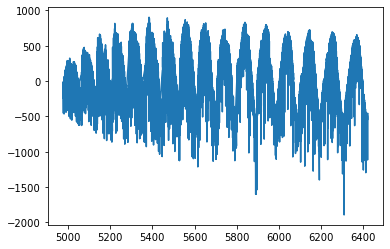

In [79]:
plt.plot(wl_interpolated,t["109409"].to_numpy())
plt.show()

In [25]:
#Post RV 
filenames = name_filename_rv_dic["FILENAME"] #Removed NAs 
temp_filenames = []
for file_name in filenames: 
    if file_name is not pd.NA: 
        temp_filenames.append(file_name.replace('r',""))
filenames = temp_filenames

In [27]:
filenames[0]
data.spectrum(filenames[0])

{'status': 'ok', 'msg': ''}

In [2]:
#Testing for Spectra
#-----------------
#What I am going to be testing is, extrcting the data from 

In [2]:
wl_solution = fits.getdata('http://caltech-ipac.github.io/hiresprv/_static/keck_rwav.fits')

In [3]:
where_they_at = "output/r20040821.211.fits"#Needs to Change after testing to where_they_at = download.localdir

In [4]:
import numpy as np
flux = fits.getdata(where_they_at)
flux_array = np.append(flux[0],[flux[i] for i in range(1,16)])
wl_solution_array = np.append(wl_solution[0],[wl_solution[i] for i in range(1,16)])

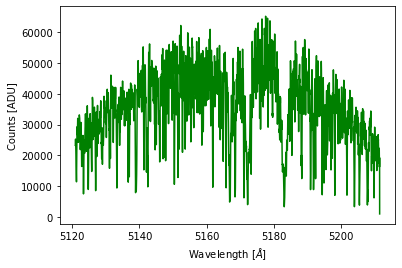

In [16]:
pl.plot(wl_solution[2,:],flux[2,:],'g')
pl.ylabel("Counts [ADU]")
pl.xlabel("Wavelength [$\AA$]")
pl.show()

In [75]:
#Continumm Normalization 

import matplotlib.pyplot as plt 
import numpy as np 
from astropy.modeling import models
from astropy import units as u
from specutils.spectra import Spectrum1D, SpectralRegion
from specutils.fitting import fit_generic_continuum


In [15]:
wl_solution = fits.getdata('http://caltech-ipac.github.io/hiresprv/_static/keck_rwav.fits')
wl_solution = np.append(wl_solution[0],[wl_solution[i] for i in range(1,16)])

In [19]:
deblazedFlux = fits.getdata("spectraOutput/r20040821.174.fits")
deblazedFlux = np.append(deblazedFlux[0],[deblazedFlux[i] for i in range(1,16)])/9.0e3

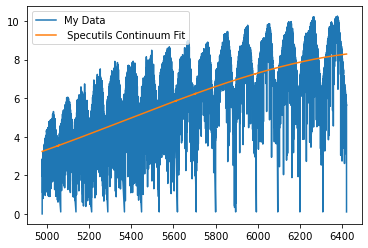

In [20]:

x = wl_solution
y = deblazedFlux
plt.plot(x, y, label = 'My Data', c='C0')

spectrum = Spectrum1D(flux=y*u.Jy, spectral_axis=x*u.um)
g1_fit = fit_generic_continuum(spectrum)
y_fit = g1_fit(x*u.um)

plt.plot(x, y_fit, label = ' Specutils Continuum Fit', c='C1')
plt.legend()

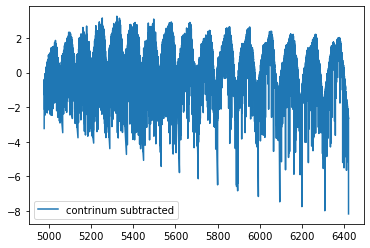

In [22]:
plt.plot(x,y - y_fit/u.Jy,label = 'contrinum subtracted')
plt.legend()
plt.show()

In [23]:
normalizedFlux = y - y_fit/u.Jy

In [27]:
y - y_fit/u.Jy

<Quantity [-3.23851812, -0.74924486, -0.80029906, ..., -5.58130506,
           -6.0609645 , -8.17777355]>

In [31]:
np.array(list(map(np.float,y_fit/u.Jy))) 

array([3.24576256, 3.24585264, 3.24594273, ..., 8.28887275, 8.28890649,
       8.28894021])

In [35]:
(y_fit/u.Jy)[0]

<Quantity 3.24576256>

In [ ]:
#Cross-corrlate 

In [ ]:
#-=================================

In [3]:
h = fits.open("output/r20071124.121.fits")

In [7]:
h = fits.open("output/r20071124.121.fits")
hdu = h[0]
hdu.header

In [2]:
import math
math.log10()

In [2]:
#Interpolate

In [8]:
d = {"Hello":(0,1),"There":(2,3)}

In [22]:
fluxnorm = [np.float64(i) for i in normalizedFlux]

In [9]:
wlDic = {}
fluxDic = {}
for HIRES_ID in spectraDic:
    wl = spectraDic[HIRES_ID][0]
    flux = spectraDic[HIRES_ID][1]
    intfunc = interpolate.interp1d(wl,flux)
    wlDic[HIRES_ID] = wl
x    fluxDic[HIRES_ID] = intfunc(wl)

return pd.DataFrame(wlDic), pd.DataFrame(fluxDic)
    


NameError: name 'spectraDic' is not defined

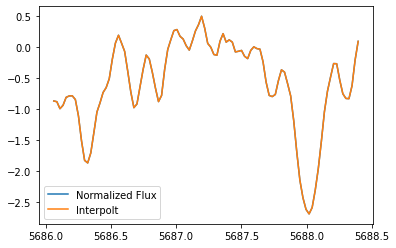

In [16]:
# get the interpolating function (you need to choose which type)
intfunc = interpolate.interp1d(x,fluxnorm,assume_sorted = True)
# plot interpolated data at high sampling
start = 35236
stop = 35336

plt.plot(x[start:stop],fluxnorm[start:stop],label = "Normalized Flux")
plt.plot(x[start:stop],intfunc(x)[start:stop],label = "Interpolt")
plt.legend()
plt.show()

In [15]:
interpolate_over = [wl for wl in x if wl >= 5000 and wl<=6000]

In [23]:

test_Interpolation = np.interp(interpolate_over,x,fluxnorm)

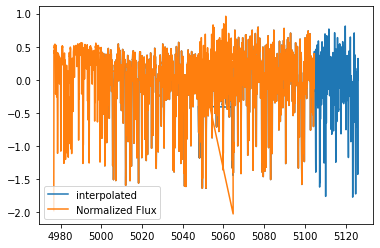

In [31]:
start = 0
stop  = 6500
plt.plot(interpolate_over[start:stop],test_Interpolation[start:stop],label = "interpolated")
plt.plot(x[start:stop],fluxnorm[start:stop],label = "Normalized Flux")
plt.legend()
plt.show()

In [3]:
#Counts to Erg/s 
#If you know the total number of counts (N) collected and the total time (t, in seconds) over which 
#the photons were collected, the rate at which the photons were collected is N/t (with units of photons/second). 
#You also have the wavelength associated with each point in the spectrum, so you can convert that to 
#energy (ergs) using E = hc/lambda, where lambda is the wavelength of light.
wl_solution = fits.getdata('http://caltech-ipac.github.io/hiresprv/_static/keck_rwav.fits')
wl_solution = np.append(wl_solution[0],[wl_solution[i] for i in range(1,16)])
deblazedFlux = fits.getdata("output/r20071124.121.fits")
deblazedFlux = np.append(deblazedFlux[0],[deblazedFlux[i] for i in range(1,16)])

In [8]:
hdu = fits.open("output/r20071124.121.fits")
timeElapsed = hdu[0].header["ELAPTIME"]

In [9]:
photonsPersec = deblazedFlux/timeElapsed

In [65]:
ergsPerSecFlux = []
for i in range(len(photonsPersec)):
    photonEnergy = 1.2398 / (wl_solution[i]*0.0001) #h*c = 1.2398 eV-µm
    ergsPerSec = photonEnergy*photonsPersec[i]
    ergsPerSecFlux.append(ergsPerSec)
ergsPerSecFlux = np.array(ergsPerSecFlux)

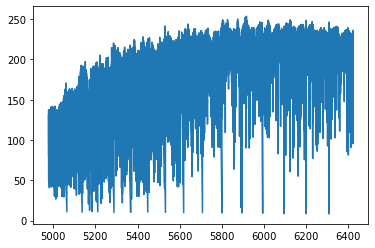

In [66]:
start = 50
stop  = len(wl_solution)-1
plt.plot(wl_solution[start:stop],ergsPerSecFlux[start:stop])
plt.show()